***L'objectif principal du projet est de créer une représentation structurée des concepts relatifs aux tendances de marché et aux sentiments en ligne. Cela implique de formaliser des ontologies qui capturent les relations entre les émotions, les événements économiques, les secteurs d’activité, et les produits***

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Initialisation de Spark
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

In [ ]:
# Chargement des données
df = spark.read.csv("Dataset.csv", header=True, inferSchema=True)
df.show()


+----------+--------------------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|    textID|                text|       selected_text|sentiment|Time of Tweet|Age of User|            Country|Population -2020|Land Area (Km�)|Density (P/Km�)|
+----------+--------------------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|cb774db0d1| I`d have respond...|I`d have responde...|  neutral|      morning|       0-20|        Afghanistan|        38928346|       652860.0|             60|
|549e992a42| Sooo SAD I will ...|            Sooo SAD| negative|         noon|      21-30|            Albania|         2877797|        27400.0|            105|
|088c60f138|my boss is bullyi...|         bullying me| negative|        night|      31-45|            Algeria|        43851044|      2381740.0|             18|
|9642c003ef| what interview! ...|      l

In [ ]:
# Nettoyage des données
df = df.na.drop()  # Supprimer les lignes avec des valeurs manquantes

# Sélection des colonnes pertinentes
df = df.select("text", "sentiment")
df.show()



+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
| I`d have respond...|  neutral|
| Sooo SAD I will ...| negative|
|my boss is bullyi...| negative|
| what interview! ...| negative|
| Sons of ****, wh...| negative|
|http://www.dotheb...|  neutral|
|2am feedings for ...| positive|
|          Soooo high|  neutral|
|         Both of you|  neutral|
| Journey!? Wow......| positive|
| as much as i lov...|  neutral|
|I really really l...| positive|
|My Sharpie is run...| negative|
|i want to go to m...| negative|
|test test from th...|  neutral|
|Uh oh, I am sunbu...| negative|
| S`ok, trying to ...| negative|
|i`ve been sick fo...| negative|
|is back home now ...| negative|
|Hes just not that...|  neutral|
+--------------------+---------+
only showing top 20 rows



In [ ]:
# Conversion des sentiments en labels numériques
from pyspark.sql.functions import when
df = df.withColumn("label", when(col("sentiment") == "positive", 1)
                                  .when(col("sentiment") == "negative", 0)
                                  .otherwise(2))
df.show()

+--------------------+---------+-----+
|                text|sentiment|label|
+--------------------+---------+-----+
| I`d have respond...|  neutral|    2|
| Sooo SAD I will ...| negative|    0|
|my boss is bullyi...| negative|    0|
| what interview! ...| negative|    0|
| Sons of ****, wh...| negative|    0|
|http://www.dotheb...|  neutral|    2|
|2am feedings for ...| positive|    1|
|          Soooo high|  neutral|    2|
|         Both of you|  neutral|    2|
| Journey!? Wow......| positive|    1|
| as much as i lov...|  neutral|    2|
|I really really l...| positive|    1|
|My Sharpie is run...| negative|    0|
|i want to go to m...| negative|    0|
|test test from th...|  neutral|    2|
|Uh oh, I am sunbu...| negative|    0|
| S`ok, trying to ...| negative|    0|
|i`ve been sick fo...| negative|    0|
|is back home now ...| negative|    0|
|Hes just not that...|  neutral|    2|
+--------------------+---------+-----+
only showing top 20 rows



In [ ]:

# Tokenization et suppression des stop words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")

In [ ]:

# Pipeline de prétraitement
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, idf])
model = pipeline.fit(df)
df = model.transform(df)

# Conversion des données en format numpy pour Keras
texts = df.select("filtered_words").rdd.flatMap(lambda x: x).collect()
labels = df.select("label").rdd.flatMap(lambda x: x).collect()

# Vectorisation du texte avec Keras
keras_tokenizer = KerasTokenizer(num_words=10000)
keras_tokenizer.fit_on_texts(texts)
sequences = keras_tokenizer.texts_to_sequences(texts)
word_index = keras_tokenizer.word_index
data = pad_sequences(sequences, maxlen=100)

# Conversion des labels en numpy array
labels = np.array(labels)


In [ ]:
import json

# Sauvegarder la configuration du tokenizer
tokenizer_config = {
    "word_index": keras_tokenizer.word_index,
    "num_words": keras_tokenizer.num_words
}

with open("tokenizer_config.json", "w") as f:
    json.dump(tokenizer_config, f)
from google.colab import files

files.download("tokenizer_config.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---------------------------------------------------------------------------------------------------

In [ ]:
!pip install rdflib

## Création des ontologies
Tweet : Représente un tweet.

Utilisateur : Représente l'utilisateur qui a posté le tweet.

Sentiment : Représente le sentiment associé au tweet (positif, négatif, neutre).

Pays : Représente le pays de l'utilisateur.

Temps : Représente l'heure à laquelle le tweet a été posté.

**Nous allons extraire des informations supplémentaires de l'ontologie pour enrichir les données textuelles. Par exemple, nous pouvons ajouter des métadonnées comme le pays de l'utilisateur ou l'heure du tweet comme caractéristiques supplémentaires.**

**Nous pouvons maintenant utiliser ces informations pour enrichir les données d'entraînement du modèle LSTM. Par exemple, nous pouvons concaténer le texte du tweet avec des métadonnées comme le pays ou l'heure.**

In [ ]:
df = spark.read.csv("Dataset.csv", header=True, inferSchema=True)

In [ ]:
from pyspark.sql.functions import col

# Vérifier les valeurs manquantes dans chaque colonne
df.select([col(c).isNull().alias(c) for c in df.columns]).groupBy().sum().show()

++
||
++
||
++



In [ ]:
df = df.na.drop(subset=["text", "Country", "Time of Tweet"])

In [ ]:
df = df.na.fill({"text": "", "Country": "Unknown", "Time of Tweet": "Unknown"})

In [ ]:
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib.namespace import RDF, RDFS, XSD
import re

# Fonction pour nettoyer les noms de pays
def clean_country_name(country_name):
    if country_name is None:
        return "Unknown"
    # Remplacer les espaces par des tirets et supprimer les caractères spéciaux
    cleaned_name = re.sub(r'[^a-zA-Z0-9]', '-', country_name)
    return cleaned_name

# Créer un graphe RDF
g = Graph()

# Définir un namespace pour notre ontologie
ns = Namespace("http://example.org/sentiment-analysis#")

# Ajouter des classes à l'ontologie
g.add((ns.Tweet, RDF.type, RDFS.Class))
g.add((ns.Utilisateur, RDF.type, RDFS.Class))
g.add((ns.Sentiment, RDF.type, RDFS.Class))
g.add((ns.Pays, RDF.type, RDFS.Class))
g.add((ns.Temps, RDF.type, RDFS.Class))

# Définir les propriétés (relations)
g.add((ns.aPourTexte, RDF.type, RDF.Property))
g.add((ns.aPourTexte, RDFS.domain, ns.Tweet))
g.add((ns.aPourTexte, RDFS.range, XSD.string))

g.add((ns.aPourPays, RDF.type, RDF.Property))
g.add((ns.aPourPays, RDFS.domain, ns.Utilisateur))
g.add((ns.aPourPays, RDFS.range, ns.Pays))

g.add((ns.aPourTemps, RDF.type, RDF.Property))
g.add((ns.aPourTemps, RDFS.domain, ns.Tweet))
g.add((ns.aPourTemps, RDFS.range, XSD.string))

# Parcourir les lignes et créer des instances dans l'ontologie
for row in df.collect():
    tweet_id = URIRef(f"http://example.org/tweet/{row['textID']}")
    utilisateur_id = URIRef(f"http://example.org/utilisateur/{row['textID']}")

    # Gérer les valeurs manquantes pour le texte
    texte = row['text'] if row['text'] is not None else ""

    # Gérer les valeurs manquantes pour le sentiment
    sentiment_value = row['sentiment'] if row['sentiment'] is not None else "neutral"
    sentiment = URIRef(f"http://example.org/sentiment/{sentiment_value}")

    # Nettoyer le nom du pays
    cleaned_country = clean_country_name(row['Country'])
    pays = URIRef(f"http://example.org/pays/{cleaned_country}")

    # Gérer les valeurs manquantes pour le temps
    temps_value = row['Time of Tweet'] if row['Time of Tweet'] is not None else "Unknown"
    temps = Literal(temps_value, datatype=XSD.string)

    # Ajouter les triplets à l'ontologie
    g.add((tweet_id, RDF.type, ns.Tweet))
    g.add((utilisateur_id, RDF.type, ns.Utilisateur))
    g.add((sentiment, RDF.type, ns.Sentiment))
    g.add((pays, RDF.type, ns.Pays))

    g.add((tweet_id, ns.aPourTexte, Literal(texte)))
    g.add((tweet_id, ns.aPourUtilisateur, utilisateur_id))
    g.add((tweet_id, ns.aPourSentiment, sentiment))
    g.add((utilisateur_id, ns.aPourPays, pays))
    g.add((tweet_id, ns.aPourTemps, temps))

# Sauvegarder l'ontologie mise à jour
g.serialize(destination="sentiment_ontology.ttl", format="turtle")

print("Ontologie mise à jour avec les données nettoyées du CSV.")

Ontologie mise à jour avec les données nettoyées du CSV.


In [ ]:
# Exemple d'enrichissement des données
enriched_texts = []
for tweet, _, _ in g.triples((None, RDF.type, ns.Tweet)):
    texte = g.value(tweet, ns.aPourTexte)
    pays = g.value(tweet, ns.aPourPays)
    temps = g.value(tweet, ns.aPourTemps)

    # Concaténer le texte avec les métadonnées
    enriched_text = f"{texte} [PAYS: {pays}] [TEMPS: {temps}]"
    enriched_texts.append(enriched_text)

# Afficher les textes enrichis
for text in enriched_texts:
    print(text)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  please don`t [PAYS: None] [TEMPS: morning]
  What`s wrong with her? [PAYS: None] [TEMPS: noon]
http://twitpic.com/6814w - So glad Sam is in a good mood [PAYS: None] [TEMPS: night]
My Tummy Hurt [PAYS: None] [TEMPS: morning]
Chillin on here [PAYS: None] [TEMPS: noon]
 indeed, much fail [PAYS: None] [TEMPS: night]
i`ll do follow friday a little later on...i`m busy taking over this lady`s job. [PAYS: None] [TEMPS: morning]
in less then a min i lost 2 followers [PAYS: None] [TEMPS: noon]
 Nah... to be honest, I`m not a `drinker` as such....  would rather have a protein shake and go for a run LOL [PAYS: None] [TEMPS: night]
 hey are you guys planning any So Cal headlining shows around the time of the Blink tour? We dont get you in Irvine [PAYS: None] [TEMPS: morning]
And I want you to shut the **** up.... I really hate living with my step dad. =-\ I can`t wait to move out... [PAYS: None] [TEMPS: noon]
uploading 

In [ ]:
from rdflib import Graph

# Charger l'ontologie depuis le fichier
g = Graph()
g.parse("sentiment_ontology.ttl", format="turtle")

# Extraire des informations spécifiques
for tweet, _, _ in g.triples((None, RDF.type, ns.Tweet)):
    # Récupérer l'utilisateur associé au tweet
    utilisateur = g.value(tweet, ns.aPourUtilisateur)
    pays = g.value(utilisateur, ns.aPourPays)
    sentiment = g.value(tweet, ns.aPourSentiment)
    temps = g.value(tweet, ns.aPourTemps)

    print(f"Tweet: {tweet}")
    print(f"Utilisateur: {utilisateur}")
    print(f"Pays: {pays}")
    print(f"Sentiment: {sentiment}")
    print(f"Temps: {temps}")
    print("---")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Temps: night
---
Tweet: http://example.org/tweet/f87c061e38
Utilisateur: http://example.org/utilisateur/f87c061e38
Pays: http://example.org/pays/Pakistan
Sentiment: http://example.org/sentiment/positive
Temps: night
---
Tweet: http://example.org/tweet/f87ca95b1d
Utilisateur: http://example.org/utilisateur/f87ca95b1d
Pays: http://example.org/pays/Georgia
Sentiment: http://example.org/sentiment/neutral
Temps: morning
---
Tweet: http://example.org/tweet/f87ce4f3cb
Utilisateur: http://example.org/utilisateur/f87ce4f3cb
Pays: http://example.org/pays/Algeria
Sentiment: http://example.org/sentiment/neutral
Temps: night
---
Tweet: http://example.org/tweet/f87e40a91b
Utilisateur: http://example.org/utilisateur/f87e40a91b
Pays: http://example.org/pays/Mauritius
Sentiment: http://example.org/sentiment/negative
Temps: noon
---
Tweet: http://example.org/tweet/f87e6f6f93
Utilisateur: http://example.org/utilisateur/f87e6f6f

In [ ]:
# enrichissement des données d'entrainement
enriched_texts = []
for tweet, _, _ in g.triples((None, RDF.type, ns.Tweet)):
    texte = g.value(tweet, ns.aPourTexte)  # Supposons que vous avez ajouté cette propriété
    pays = g.value(tweet, ns.aPourPays)
    temps = g.value(tweet, ns.aPourTemps)

    # Concaténer le texte avec les métadonnées
    enriched_text = f"{texte} [PAYS: {pays}] [TEMPS: {temps}]"
    enriched_texts.append(enriched_text)

# Afficher les textes enrichis
for text in enriched_texts:
    print(text)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Good night everyone...... Time to go mimmiz...... [PAYS: None] [TEMPS: noon]
is bored hehehe  i hate IPT [PAYS: None] [TEMPS: noon]
learning french  funy school-day today  don`t be mad about english :*:* [PAYS: None] [TEMPS: night]
Found out I have to go to the US again in August. Getting tired of transatlantic flights. Not good for my carbon footprint either [PAYS: None] [TEMPS: noon]
 me too i hate revision [PAYS: None] [TEMPS: morning]
i do indeed have tonsillitis. the only good thing: ive been advised to eat lots of ice cream. [but no solid foods  & im bed ridden.] [PAYS: None] [TEMPS: noon]
_ was yeah... work in 7 hrs  how you [PAYS: None] [TEMPS: noon]
_anekie ok darl, i will suggest you to the MUA (Tracie Weaver), as she`ll be making the decision [PAYS: None] [TEMPS: noon]
 I`m sure the Mrs. will follow when she gets comfortable on the new computer, may be a while  #hhrs [PAYS: None] [TEMPS: noon]
 i p

In [ ]:
from rdflib import Graph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS
import networkx as nx
import matplotlib.pyplot as plt

# Charger l'ontologie depuis le fichier Turtle
g = Graph()
g.parse("sentiment_ontology.ttl", format="turtle")

# Créer un graphe networkx
nx_graph = nx.DiGraph()

# Ajouter les nœuds et les arêtes au graphe networkx
for s, p, o in g:
    if isinstance(s, URIRef) and isinstance(o, URIRef):
        nx_graph.add_edge(str(s), str(o), label=str(p))

# Visualiser le graphe
pos = nx.spring_layout(nx_graph, seed=42)  # Positionnement des nœuds
labels = nx.get_edge_attributes(nx_graph, 'label')

plt.figure(figsize=(12, 8))
nx.draw(nx_graph, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold")
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=labels, font_color='red')
plt.title("Visualisation de l'Ontologie RDF")
plt.show()

**Étapes :**

*a. Identifier les Nouveaux Concepts*
Sentiments : Positif, négatif, neutre.

Opinions : Avis, commentaires, critiques.

Tendances de consommation : Hausse, baisse, stagnation.

Secteurs d'activité : Technologie, alimentation, mode, etc.

Produits/Marques : Produits spécifiques, marques, catégories de produits.

*b. Définir les Relations*
Un sentiment positif sur un produit peut entraîner une tendance à la hausse de la demande.

Un changement d'opinion sur une marque peut entraîner un changement de parts de marché.

Un événement (comme un lancement de produit) peut influencer les tendances de consommation.



Danc cette partie on va enrichir nore ontologie existante par de nouveaux concepts . La nouvelle base de donnée "Product" :

Cette base de données contient des informations structurées sur :

Produits : Nom, marque, catégorie, ingrédients, prix, etc.

Sentiments : Notes, avis, et tendances de consommation.

Secteurs : Catégories primaires, secondaires et tertiaires.

Tendances : Popularité, demandes, et caractéristiques des produits.

Cela nous permettra de :

Créer une ontologie plus complète en intégrant ces concepts.

Analyser les tendances de marché de manière plus réaliste.

Générer des recommandations basées sur des données réelles.

In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
# Initialiser Spark
spark = SparkSession.builder.appName("MarketTrendsAnalysis").getOrCreate()

# Charger les données
df = spark.read.csv("Product.csv", header=True, inferSchema=True)
df.show(5)

+----------+--------------------+--------+----------+-----------+------+-------+--------------+--------------------+---------------+--------------+--------------------+---------+---------------+--------------+---------------+---+-----------+------------+-----------------+--------------------+----------------+------------------+-----------------+-----------+---------------+---------------+
|product_id|        product_name|brand_id|brand_name|loves_count|rating|reviews|          size|      variation_type|variation_value|variation_desc|         ingredients|price_usd|value_price_usd|sale_price_usd|limited_edition|new|online_only|out_of_stock|sephora_exclusive|          highlights|primary_category|secondary_category|tertiary_category|child_count|child_max_price|child_min_price|
+----------+--------------------+--------+----------+-----------+------+-------+--------------+--------------------+---------------+--------------+--------------------+---------+---------------+--------------+-------

In [ ]:
from pyspark.sql.functions import col

# Convertir les listes en chaînes de caractères
df = df.withColumn("ingredients", col("ingredients").cast("string"))
df = df.withColumn("highlights", col("highlights").cast("string"))

# Afficher les premières lignes pour vérifier
df.select("product_id", "ingredients", "highlights").show(5, truncate=False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Supprimer les lignes où les colonnes essentielles sont manquantes
df = df.na.drop(subset=["product_id", "product_name", "brand_name", "primary_category", "rating"])

In [ ]:
from pyspark.sql.functions import lower

df = df.withColumn("product_name", lower(col("product_name")))
df = df.withColumn("brand_name", lower(col("brand_name")))
df = df.withColumn("primary_category", lower(col("primary_category")))

In [ ]:
columns_to_keep = ["product_id", "product_name", "brand_id", "brand_name", "primary_category", "rating", "reviews", "ingredients", "highlights"]
df_selected = df.select(columns_to_keep)

# Afficher les premières lignes
df_selected.show(5, truncate=False)

+----------+-------------------------+--------+----------+----------------+------+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import re

def clean_ingredient_name(ingredient):
    # Remplacer les espaces par des tirets
    ingredient = ingredient.replace(" ", "-")
    # Supprimer les caractères spéciaux non valides
    ingredient = re.sub(r'[^a-zA-Z0-9\-]', '', ingredient)
    return ingredient.lower()  # Convertir en minuscules pour uniformité

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Enregistrer la fonction comme UDF (User Defined Function)
clean_ingredient_udf = udf(clean_ingredient_name, StringType())

# Appliquer la fonction à la colonne "ingredients"
df_selected = df_selected.withColumn("cleaned_ingredients", clean_ingredient_udf(col("ingredients")))

# Afficher les premières lignes pour vérifier
df_selected.select("ingredients", "cleaned_ingredients").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import when

# Remplacer les valeurs `None` par une chaîne vide
df_selected = df_selected.withColumn("ingredients", when(col("ingredients").isNull(), "").otherwise(col("ingredients")))

In [ ]:
# Supprimer les lignes où "ingredients" est `None`
df_selected = df_selected.na.drop(subset=["ingredients"])

In [ ]:
from pyspark.sql.functions import col, count, when

# Compter les valeurs `None` dans la colonne "ingredients"
null_count = df_selected.filter(col("ingredients").isNull()).count()
print(f"Nombre de valeurs 'None' dans 'ingredients': {null_count}")

Nombre de valeurs 'None' dans 'ingredients': 0


In [ ]:

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Enregistrer la fonction comme UDF (User Defined Function)
clean_ingredient_udf = udf(clean_ingredient_name, StringType())

# Appliquer la fonction à la colonne "ingredients"
df_selected = df_selected.withColumn("cleaned_ingredients", clean_ingredient_udf(col("ingredients")))

# Afficher les premières lignes pour vérifier
df_selected.select("ingredients", "cleaned_ingredients").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import re

def clean_highlight_name(highlight):
    if highlight is None or highlight.strip() == "":
        return ""  # Retourner une chaîne vide si le highlight est `None` ou vide

    # Si le highlight est une liste (ex: "['Good for: Damage', 'Clean at Sephora']")
    if highlight.startswith("[") and highlight.endswith("]"):
        highlight = highlight[1:-1]  # Supprimer les crochets
        highlight = highlight.replace("'", "")  # Supprimer les guillemets simples

    # Remplacer les espaces par des tirets
    highlight = highlight.replace(" ", "-")
    # Supprimer les caractères spéciaux non valides
    highlight = re.sub(r'[^a-zA-Z0-9\-]', '', highlight)
    return highlight.lower()  # Convertir en minuscules pour uniformité

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Enregistrer la fonction comme UDF (User Defined Function)
clean_highlight_udf = udf(clean_highlight_name, StringType())

# Appliquer la fonction à la colonne "highlights"
df_selected = df_selected.withColumn("cleaned_highlights", clean_highlight_udf(col("highlights")))

# Afficher les premières lignes pour vérifier
df_selected.select("highlights", "cleaned_highlights").show(5, truncate=False)

+----------------------------------------------------------------------------------------+------------------------------------------------------------------------+
|highlights                                                                              |cleaned_highlights                                                      |
+----------------------------------------------------------------------------------------+------------------------------------------------------------------------+
|['Unisex/ Genderless Scent', 'Warm &Spicy Scent', 'Woody & Earthy Scent', 'Fresh Scent']|unisex-genderless-scent-warm-spicy-scent-woody--earthy-scent-fresh-scent|
|['Unisex/ Genderless Scent', 'Layerable Scent', 'Warm &Spicy Scent']                    |unisex-genderless-scent-layerable-scent-warm-spicy-scent                |
|['Unisex/ Genderless Scent', 'Layerable Scent', 'Woody & Earthy Scent']                 |unisex-genderless-scent-layerable-scent-woody--earthy-scent             |
|['Unisex/ Gende

In [ ]:
import re

def clean_sector_name(sector):
    if sector is None or sector.strip() == "":
        return ""  # Retourner une chaîne vide si le secteur est `None` ou vide

    # Remplacer les espaces par des tirets
    sector = sector.replace(" ", "-")
    # Supprimer les caractères spéciaux non valides
    sector = re.sub(r'[^a-zA-Z0-9\-]', '', sector)
    return sector.lower()  # Convertir en minuscules pour uniformité

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Enregistrer la fonction comme UDF (User Defined Function)
clean_sector_udf = udf(clean_sector_name, StringType())

# Appliquer la fonction à la colonne "primary_category"
df_selected = df_selected.withColumn("cleaned_primary_category", clean_sector_udf(col("primary_category")))

# Afficher les premières lignes pour vérifier
df_selected.select("primary_category", "cleaned_primary_category").show(5, truncate=False)

+----------------+------------------------+
|primary_category|cleaned_primary_category|
+----------------+------------------------+
|fragrance       |fragrance               |
|fragrance       |fragrance               |
|fragrance       |fragrance               |
|fragrance       |fragrance               |
|fragrance       |fragrance               |
+----------------+------------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, ArrayType
import re
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD



# Initialiser Spark
spark = SparkSession.builder.appName("MarketTrendsAnalysis").getOrCreate()

# Charger les données
df = spark.read.csv("Product.csv", header=True, inferSchema=True)

# Afficher les premières lignes pour vérifier
df.show(5)

# 1. Gérer les Valeurs Manquantes
df = df.fillna({
    'rating': 0,
    'reviews': 0,
    'size': '',
    'variation_type': '',
    'variation_value': '',
    'variation_desc': '',
    'ingredients': '',
    'highlights': '',
    'secondary_category': '',
    'tertiary_category': '',
    'child_max_price': 0,
    'child_min_price': 0
})

# 2. Nettoyer les Colonnes Textuelles
def clean_text(text):
    if text is None:
        return ""
    # Supprimer les crochets et les guillemets simples
    text = text.replace("[", "").replace("]", "").replace("'", "")
    # Supprimer les espaces inutiles
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Enregistrer la fonction comme UDF (User Defined Function)
clean_text_udf = udf(clean_text, StringType())

# Appliquer la fonction aux colonnes textuelles
df = df.withColumn("ingredients", clean_text_udf(col("ingredients")))
df = df.withColumn("highlights", clean_text_udf(col("highlights")))

# 3. Convertir les Colonnes en Listes
def split_string_to_list(text):
    if text is None or text.strip() == "":
        return []
    return text.split(", ")

# Enregistrer la fonction comme UDF
split_string_to_list_udf = udf(split_string_to_list, ArrayType(StringType()))

# Appliquer la fonction aux colonnes `ingredients` et `highlights`
df = df.withColumn("ingredients", split_string_to_list_udf(col("ingredients")))
df = df.withColumn("highlights", split_string_to_list_udf(col("highlights")))

# 4. Supprimer les Colonnes Inutiles (optionnel)
columns_to_drop = ["value_price_usd", "sale_price_usd", "new", "online_only", "out_of_stock", "sephora_exclusive"]

# Vérifier si 'limited_edition' existe avant de l'ajouter à la liste des colonnes à supprimer
if 'limited_edition' in df.columns:
    columns_to_drop.append("limited_edition")

# Supprimer les colonnes inutiles
df = df.drop(*columns_to_drop)

# Afficher les premières lignes après nettoyage
df.show(5)

# Afficher le schéma pour vérifier les types de données
df.printSchema()

+----------+--------------------+--------+----------+-----------+------+-------+--------------+--------------------+---------------+--------------+--------------------+---------+---------------+--------------+---------------+---+-----------+------------+-----------------+--------------------+----------------+------------------+-----------------+-----------+---------------+---------------+
|product_id|        product_name|brand_id|brand_name|loves_count|rating|reviews|          size|      variation_type|variation_value|variation_desc|         ingredients|price_usd|value_price_usd|sale_price_usd|limited_edition|new|online_only|out_of_stock|sephora_exclusive|          highlights|primary_category|secondary_category|tertiary_category|child_count|child_max_price|child_min_price|
+----------+--------------------+--------+----------+-----------+------+-------+--------------+--------------------+---------------+--------------+--------------------+---------+---------------+--------------+-------

In [ ]:
from pyspark.sql.types import IntegerType, DoubleType

# Convert columns to appropriate data types
df = df.withColumn("loves_count", col("loves_count").cast(IntegerType())) \
       .withColumn("rating", col("rating").cast(DoubleType())) \
       .withColumn("reviews", col("reviews").cast(IntegerType())) \
       .withColumn("child_count", col("child_count").cast(IntegerType())) \
       .withColumn("child_max_price", col("child_max_price").cast(DoubleType())) \
       .withColumn("child_min_price", col("child_min_price").cast(DoubleType()))

In [ ]:
from pyspark.sql.functions import when

# Replace empty strings with NULL
df = df.withColumn("size", when(col("size") == "", None).otherwise(col("size"))) \
       .withColumn("variation_type", when(col("variation_type") == "", None).otherwise(col("variation_type"))) \
       .withColumn("variation_value", when(col("variation_value") == "", None).otherwise(col("variation_value"))) \
       .withColumn("variation_desc", when(col("variation_desc") == "", None).otherwise(col("variation_desc")))

In [ ]:
from pyspark.sql.functions import coalesce, lit

# Fill NULL values in text columns with "Unknown"
df = df.withColumn("size", coalesce(col("size"), lit("Unknown"))) \
       .withColumn("variation_type", coalesce(col("variation_type"), lit("Unknown"))) \
       .withColumn("variation_value", coalesce(col("variation_value"), lit("Unknown"))) \
       .withColumn("variation_desc", coalesce(col("variation_desc"), lit("Unknown")))

In [ ]:
from pyspark.sql.functions import expr

# Clean array columns
df = df.withColumn("ingredients", expr("transform(ingredients, x -> trim(x))")) \
       .withColumn("highlights", expr("transform(highlights, x -> trim(x))"))

In [ ]:
# Print schema
df.printSchema()

# Show sample data
df.show(5)

root
 |-- product_id: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- brand_id: string (nullable = true)
 |-- brand_name: string (nullable = true)
 |-- loves_count: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- reviews: integer (nullable = true)
 |-- size: string (nullable = false)
 |-- variation_type: string (nullable = false)
 |-- variation_value: string (nullable = false)
 |-- variation_desc: string (nullable = false)
 |-- ingredients: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price_usd: double (nullable = true)
 |-- highlights: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- primary_category: string (nullable = true)
 |-- secondary_category: string (nullable = false)
 |-- tertiary_category: string (nullable = false)
 |-- child_count: integer (nullable = true)
 |-- child_max_price: double (nullable = true)
 |-- child_min_price: double (nullable = true)

+----------+------

In [ ]:
from pyspark.sql.functions import when

# Replace empty strings with NULL
df = df.withColumn("size", when(col("size") == "", None).otherwise(col("size"))) \
       .withColumn("variation_type", when(col("variation_type") == "", None).otherwise(col("variation_type"))) \
       .withColumn("variation_value", when(col("variation_value") == "", None).otherwise(col("variation_value"))) \
       .withColumn("variation_desc", when(col("variation_desc") == "", None).otherwise(col("variation_desc")))

In [ ]:
from pyspark.sql.functions import expr

# Clean array columns
df = df.withColumn("ingredients", expr("transform(ingredients, x -> trim(x))")) \
       .withColumn("highlights", expr("transform(highlights, x -> trim(x))"))

In [ ]:
# Check for duplicates
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

# Drop duplicates if necessary
df = df.dropDuplicates()

Number of duplicate rows: 0


In [ ]:
from pyspark.sql.functions import col

# Validate numeric columns
df = df.filter((col("rating") >= 0) & (col("price_usd") >= 0) &
               (col("child_max_price") >= 0) & (col("child_min_price") >= 0))

In [ ]:
# Save the cleaned dataset to a Parquet file
df.write.parquet("cleaned_product_data.parquet", mode="overwrite")

In [ ]:
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD
from urllib.parse import quote

# Initialiser le graphe RDF
g = Graph()

# Définir le namespace de l'ontologie
ns = Namespace("http://example.org/market-trends#")

# Ajouter les classes à l'ontologie
g.add((ns.Produit, RDF.type, RDFS.Class))
g.add((ns.Marque, RDF.type, RDFS.Class))
g.add((ns.Catégorie, RDF.type, RDFS.Class))
g.add((ns.Ingrédient, RDF.type, RDFS.Class))
g.add((ns.Avis, RDF.type, RDFS.Class))
g.add((ns.Tendance, RDF.type, RDFS.Class))
g.add((ns.Prix, RDF.type, RDFS.Class))
g.add((ns.StatutProduit, RDF.type, RDFS.Class))
g.add((ns.Highlight, RDF.type, RDFS.Class))

# Définir les propriétés
g.add((ns.aPourMarque, RDF.type, RDF.Property))
g.add((ns.aPourMarque, RDFS.domain, ns.Produit))
g.add((ns.aPourMarque, RDFS.range, ns.Marque))

g.add((ns.appartientA, RDF.type, RDF.Property))
g.add((ns.appartientA, RDFS.domain, ns.Produit))
g.add((ns.appartientA, RDFS.range, ns.Catégorie))

g.add((ns.contientIngrédient, RDF.type, RDF.Property))
g.add((ns.contientIngrédient, RDFS.domain, ns.Produit))
g.add((ns.contientIngrédient, RDFS.range, ns.Ingrédient))

g.add((ns.aPourAvis, RDF.type, RDF.Property))
g.add((ns.aPourAvis, RDFS.domain, ns.Produit))
g.add((ns.aPourAvis, RDFS.range, ns.Avis))

g.add((ns.influenceTendance, RDF.type, RDF.Property))
g.add((ns.influenceTendance, RDFS.domain, ns.Avis))
g.add((ns.influenceTendance, RDFS.range, ns.Tendance))

g.add((ns.aPourPrix, RDF.type, RDF.Property))
g.add((ns.aPourPrix, RDFS.domain, ns.Produit))
g.add((ns.aPourPrix, RDFS.range, ns.Prix))

g.add((ns.aPourStatut, RDF.type, RDF.Property))
g.add((ns.aPourStatut, RDFS.domain, ns.Produit))
g.add((ns.aPourStatut, RDFS.range, ns.StatutProduit))

g.add((ns.aPourHighlight, RDF.type, RDF.Property))
g.add((ns.aPourHighlight, RDFS.domain, ns.Produit))
g.add((ns.aPourHighlight, RDFS.range, ns.Highlight))

g.add((ns.aPourNote, RDF.type, RDF.Property))
g.add((ns.aPourNote, RDFS.domain, ns.Produit))
g.add((ns.aPourNote, RDFS.range, XSD.float))

g.add((ns.aPourAvisCount, RDF.type, RDF.Property))
g.add((ns.aPourAvisCount, RDFS.domain, ns.Produit))
g.add((ns.aPourAvisCount, RDFS.range, XSD.integer))

# Ajouter des instances pour les tendances
tendance_hausse = URIRef("http://example.org/tendance/hausse")
tendance_baisse = URIRef("http://example.org/tendance/baisse")
tendance_stagnation = URIRef("http://example.org/tendance/stagnation")

g.add((tendance_hausse, RDF.type, ns.Tendance))
g.add((tendance_baisse, RDF.type, ns.Tendance))
g.add((tendance_stagnation, RDF.type, ns.Tendance))

# Fonction pour nettoyer les URIs
def clean_uri(value):
    if value is None:
        return ""
    return quote(str(value))

# Parcourir la base de données nettoyée pour ajouter les instances
for row in df.collect():
    # Vérifier si les valeurs critiques sont présentes
    if row['product_id'] is None or row['brand_id'] is None or row['primary_category'] is None:
        print(f"Skipping row with missing critical values: {row}")
        continue

    # Créer des URIRef pour chaque instance
    produit = URIRef(f"http://example.org/produit/{clean_uri(row['product_id'])}")
    marque = URIRef(f"http://example.org/marque/{clean_uri(row['brand_id'])}")
    catégorie = URIRef(f"http://example.org/catégorie/{clean_uri(row['primary_category'])}")

    # Convertir la liste d'ingrédients en une chaîne de caractères avant de hacher
    ingredients_str = ", ".join(row['ingredients']) if row['ingredients'] else ""
    ingrédient = URIRef(f"http://example.org/ingrédient/{hash(ingredients_str)}")

    avis = URIRef(f"http://example.org/avis/{clean_uri(row['product_id'])}")
    prix = URIRef(f"http://example.org/prix/{clean_uri(row['product_id'])}")
    statut = URIRef(f"http://example.org/statut/{clean_uri(row['product_id'])}")
    highlight = URIRef(f"http://example.org/highlight/{clean_uri(row['product_id'])}")

    # Ajouter les instances à l'ontologie
    g.add((produit, RDF.type, ns.Produit))
    g.add((marque, RDF.type, ns.Marque))
    g.add((catégorie, RDF.type, ns.Catégorie))
    g.add((ingrédient, RDF.type, ns.Ingrédient))
    g.add((avis, RDF.type, ns.Avis))
    g.add((prix, RDF.type, ns.Prix))
    g.add((statut, RDF.type, ns.StatutProduit))
    g.add((highlight, RDF.type, ns.Highlight))

    # Lier le produit à ses propriétés
    g.add((produit, ns.aPourMarque, marque))
    g.add((produit, ns.appartientA, catégorie))
    g.add((produit, ns.contientIngrédient, ingrédient))
    g.add((produit, ns.aPourAvis, avis))
    g.add((produit, ns.aPourPrix, prix))
    g.add((produit, ns.aPourStatut, statut))
    g.add((produit, ns.aPourHighlight, highlight))

    # Ajouter la note et le nombre d'avis
    if row['rating'] is not None:
        g.add((produit, ns.aPourNote, Literal(float(row['rating']), datatype=XSD.float)))
    if row['reviews'] is not None:
        g.add((produit, ns.aPourAvisCount, Literal(int(row['reviews']), datatype=XSD.integer)))

    # Ajouter des informations supplémentaires pour le prix, le statut, etc.
    if row['price_usd'] is not None:
        g.add((prix, ns.valeur, Literal(float(row['price_usd']), datatype=XSD.float)))

    # Lier l'avis à une tendance (exemple basé sur le rating)
    if row['rating'] is not None:
        if row['rating'] >= 4.0:
            g.add((avis, ns.influenceTendance, tendance_hausse))
        elif row['rating'] <= 2.0:
            g.add((avis, ns.influenceTendance, tendance_baisse))
        else:
            g.add((avis, ns.influenceTendance, tendance_stagnation))

# Sauvegarder l'ontologie dans un fichier
g.serialize(destination="market_trends_ontology.ttl", format="turtle")
print("Ontologie des tendances de marché créée et sauvegardée dans 'market_trends_ontology_with_data.ttl'.")

Ontologie des tendances de marché créée et sauvegardée dans 'market_trends_ontology_with_data.ttl'.


In [ ]:
from rdflib import Graph

# Charger l'ontologie depuis le fichier Turtle
g = Graph()
g.parse("market_trends_ontology.ttl", format="turtle")

# Afficher le nombre de triplets dans le graphe
print(f"Nombre de triplets dans l'ontologie de market trends : {len(g)}")

Nombre de triplets dans l'ontologie de market trends : 142721


In [ ]:
from rdflib import Graph

# Charger l'ontologie depuis le fichier Turtle
g = Graph()
g.parse("sentiment_ontology.ttl", format="turtle")

# Afficher le nombre de triplets dans le graphe
print(f"Nombre de triplets dans l'ontologie  de sentiments : {len(g)}")

Nombre de triplets dans l'ontologie  de sentiments : 192558


In [ ]:
# Requête SPARQL pour lister tous les produits
query = """
    PREFIX ns: <http://example.org/market-trends#>
    SELECT ?produit
    WHERE {
        ?produit a ns:Produit .
    }
"""

# Exécuter la requête
results = g.query(query)

# Afficher les résultats
print("Liste des produits :")
for row in results:
    print(row.produit)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
http://example.org/produit/P455660
http://example.org/produit/P455661
http://example.org/produit/P455662
http://example.org/produit/P455663
http://example.org/produit/P455664
http://example.org/produit/P455676
http://example.org/produit/P455833
http://example.org/produit/P455835
http://example.org/produit/P455838
http://example.org/produit/P455839
http://example.org/produit/P455840
http://example.org/produit/P455841
http://example.org/produit/P455842
http://example.org/produit/P455843
http://example.org/produit/P455844
http://example.org/produit/P455846
http://example.org/produit/P455849
http://example.org/produit/P455850
http://example.org/produit/P455851
http://example.org/produit/P455852
http://example.org/produit/P455853
http://example.org/produit/P455854
http://example.org/produit/P455855
http://example.org/produit/P455856
http://example.org/produit/P455857
http://example.org/produit/P455858
http://examp

In [ ]:
# Requête SPARQL pour lister les produits avec leurs marques
query = """
    PREFIX ns: <http://example.org/market-trends#>
    SELECT ?produit ?marque
    WHERE {
        ?produit a ns:Produit .
        ?produit ns:aPourMarque ?marque .
    }
"""

# Exécuter la requête
results = g.query(query)

# Afficher les résultats
print("Produits avec leurs marques :")
for row in results:
    print(f"Produit : {row.produit}, Marque : {row.marque}")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Produit : http://example.org/produit/P455660, Marque : http://example.org/marque/3902
Produit : http://example.org/produit/P455661, Marque : http://example.org/marque/3902
Produit : http://example.org/produit/P455662, Marque : http://example.org/marque/3902
Produit : http://example.org/produit/P455663, Marque : http://example.org/marque/3902
Produit : http://example.org/produit/P455664, Marque : http://example.org/marque/3902
Produit : http://example.org/produit/P455676, Marque : http://example.org/marque/6316
Produit : http://example.org/produit/P455833, Marque : http://example.org/marque/6304
Produit : http://example.org/produit/P455835, Marque : http://example.org/marque/6315
Produit : http://example.org/produit/P455838, Marque : http://example.org/marque/6315
Produit : http://example.org/produit/P455839, Marque : http://example.org/marque/6315
Produit : http://example.org/produit/P455840, Marque : http://

In [ ]:
# Requête SPARQL pour lister les produits avec leurs catégories
query = """
    PREFIX ns: <http://example.org/market-trends#>
    SELECT ?produit ?catégorie
    WHERE {
        ?produit a ns:Produit .
        ?produit ns:appartientA ?catégorie .
    }
"""

# Exécuter la requête
results = g.query(query)

# Afficher les résultats
print("Produits avec leurs catégories :")
for row in results:
    print(f"Produit : {row.produit}, Catégorie : {row.catégorie}")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Produit : http://example.org/produit/P455660, Catégorie : http://example.org/catégorie/Makeup
Produit : http://example.org/produit/P455661, Catégorie : http://example.org/catégorie/Makeup
Produit : http://example.org/produit/P455662, Catégorie : http://example.org/catégorie/Makeup
Produit : http://example.org/produit/P455663, Catégorie : http://example.org/catégorie/Makeup
Produit : http://example.org/produit/P455664, Catégorie : http://example.org/catégorie/Makeup
Produit : http://example.org/produit/P455676, Catégorie : http://example.org/catégorie/Skincare
Produit : http://example.org/produit/P455833, Catégorie : http://example.org/catégorie/Hair
Produit : http://example.org/produit/P455835, Catégorie : http://example.org/catégorie/Hair
Produit : http://example.org/produit/P455838, Catégorie : http://example.org/catégorie/Hair
Produit : http://example.org/produit/P455839, Catégorie : http://example.org/cat

In [ ]:
# Requête SPARQL pour lister les produits avec leurs notes et nombre d'avis
query = """
    PREFIX ns: <http://example.org/market-trends#>
    SELECT ?produit ?note ?avisCount
    WHERE {
        ?produit a ns:Produit .
        ?produit ns:aPourNote ?note .
        ?produit ns:aPourAvisCount ?avisCount .
    }
"""

# Exécuter la requête
results = g.query(query)

# Afficher les résultats
print("Produits avec leurs notes et nombre d'avis :")
for row in results:
    print(f"Produit : {row.produit}, Note : {row.note}, Nombre d'avis : {row.avisCount}")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Produit : http://example.org/produit/P455660, Note : 4.6429, Nombre d'avis : 14
Produit : http://example.org/produit/P455661, Note : 4.7232, Nombre d'avis : 112
Produit : http://example.org/produit/P455662, Note : 4.75, Nombre d'avis : 16
Produit : http://example.org/produit/P455663, Note : 4.7143, Nombre d'avis : 7
Produit : http://example.org/produit/P455664, Note : 4.3636, Nombre d'avis : 11
Produit : http://example.org/produit/P455676, Note : 4.246, Nombre d'avis : 2207
Produit : http://example.org/produit/P455833, Note : 4.1667, Nombre d'avis : 6
Produit : http://example.org/produit/P455835, Note : 4.3531, Nombre d'avis : 286
Produit : http://example.org/produit/P455838, Note : 3.5882, Nombre d'avis : 17
Produit : http://example.org/produit/P455839, Note : 4.6786, Nombre d'avis : 28
Produit : http://example.org/produit/P455840, Note : 3.4615, Nombre d'avis : 13
Produit : http://example.org/produit/P45584

In [ ]:
# Requête SPARQL pour lister les tendances influencées par les avis
query = """
    PREFIX ns: <http://example.org/market-trends#>
    SELECT ?avis ?tendance
    WHERE {
        ?avis a ns:Avis .
        ?avis ns:influenceTendance ?tendance .
    }
"""

# Exécuter la requête
results = g.query(query)

# Afficher les résultats
print("Tendances influencées par les avis :")
for row in results:
    print(f"Avis : {row.avis}, Tendance : {row.tendance}")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Avis : http://example.org/avis/P455660, Tendance : http://example.org/tendance/hausse
Avis : http://example.org/avis/P455661, Tendance : http://example.org/tendance/hausse
Avis : http://example.org/avis/P455662, Tendance : http://example.org/tendance/hausse
Avis : http://example.org/avis/P455663, Tendance : http://example.org/tendance/hausse
Avis : http://example.org/avis/P455664, Tendance : http://example.org/tendance/hausse
Avis : http://example.org/avis/P455676, Tendance : http://example.org/tendance/hausse
Avis : http://example.org/avis/P455833, Tendance : http://example.org/tendance/hausse
Avis : http://example.org/avis/P455835, Tendance : http://example.org/tendance/hausse
Avis : http://example.org/avis/P455838, Tendance : http://example.org/tendance/stagnation
Avis : http://example.org/avis/P455839, Tendance : http://example.org/tendance/hausse
Avis : http://example.org/avis/P455840, Tendance : http://

Concepts communs :
Produit : Représenté dans les deux ontologies.

Sentiment : Présent dans sentiment_ontology.ttl et peut être lié aux avis dans market_trends_ontology.ttl.

Tendances : Présent dans market_trends_ontology.ttl et peut être enrichi avec des données de sentiment.

Nouveaux concepts à ajouter :
Opinions : Avis, commentaires, critiques.

Tendances de consommation : Hausse, baisse, stagnation.

Secteurs d'activité : Technologie, alimentation, mode, etc.

Événements : Lancements de produits, campagnes marketing, etc.

Un sentiment positif sur un produit peut entraîner une tendance à la hausse de la demande.

Un changement d'opinion sur une marque peut entraîner un changement de parts de marché.

Un événement (comme un lancement de produit) peut influencer les tendances de consommation.

2. Relations entre Concepts
2.1. Relations de Base
Sentiment → Opinion : Un sentiment peut influencer une opinion.

Opinion → Tendance de Consommation : Une opinion peut influencer une tendance de consommation.

Tendance de Consommation → Secteur d’Activité : Une tendance de consommation peut affecter un secteur d’activité.

2.2. Relations Spécifiques
Sentiment Positif sur un Produit → Tendance à la Hausse de la Demande : Un sentiment positif sur un produit peut entraîner une augmentation de la demande.

Changement d'Opinion sur une Marque → Changement Potentiel de Parts de Marché : Un changement d'opinion sur une marque peut affecter ses parts de marché.

Sentiment Négatif sur un Produit → Tendance à la Baisse de la Demande : Un sentiment négatif sur un produit peut entraîner une diminution de la demande.

Opinion Positive sur un Secteur → Tendance à la Hausse dans le Secteur : Une opinion positive sur un secteur peut entraîner une tendance à la hausse dans ce secteur.

In [ ]:
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib.namespace import RDF, RDFS, XSD

# Charger les ontologies existantes
sentiment_graph = Graph()
sentiment_graph.parse("sentiment_ontology.ttl", format="turtle")

market_trends_graph = Graph()
market_trends_graph.parse("market_trends_ontology.ttl", format="turtle")

# Créer un graphe pour l'ontologie unifiée
unified_graph = Graph()

# Définir le namespace pour l'ontologie unifiée
ns = Namespace("http://example.org/unified-ontology#")

# Ajouter les classes communes
unified_graph.add((ns.Tweet, RDF.type, RDFS.Class))
unified_graph.add((ns.Utilisateur, RDF.type, RDFS.Class))
unified_graph.add((ns.Sentiment, RDF.type, RDFS.Class))
unified_graph.add((ns.Pays, RDF.type, RDFS.Class))
unified_graph.add((ns.Temps, RDF.type, RDFS.Class))
unified_graph.add((ns.Produit, RDF.type, RDFS.Class))
unified_graph.add((ns.Marque, RDF.type, RDFS.Class))
unified_graph.add((ns.Catégorie, RDF.type, RDFS.Class))
unified_graph.add((ns.Avis, RDF.type, RDFS.Class))
unified_graph.add((ns.Tendance, RDF.type, RDFS.Class))

# Ajouter les nouvelles classes
unified_graph.add((ns.Opinion, RDF.type, RDFS.Class))
unified_graph.add((ns.TendanceConsommation, RDF.type, RDFS.Class))
unified_graph.add((ns.SecteurActivite, RDF.type, RDFS.Class))
unified_graph.add((ns.Événement, RDF.type, RDFS.Class))
unified_graph.add((ns.Émotion, RDF.type, RDFS.Class))
unified_graph.add((ns.Contexte, RDF.type, RDFS.Class))
unified_graph.add((ns.RelationProduit, RDF.type, RDFS.Class))
unified_graph.add((ns.ImpactÉconomique, RDF.type, RDFS.Class))

# Ajouter les propriétés communes
unified_graph.add((ns.aPourTexte, RDF.type, RDF.Property))
unified_graph.add((ns.aPourTexte, RDFS.domain, ns.Tweet))
unified_graph.add((ns.aPourTexte, RDFS.range, XSD.string))

unified_graph.add((ns.aPourPays, RDF.type, RDF.Property))
unified_graph.add((ns.aPourPays, RDFS.domain, ns.Utilisateur))
unified_graph.add((ns.aPourPays, RDFS.range, ns.Pays))

unified_graph.add((ns.aPourTemps, RDF.type, RDF.Property))
unified_graph.add((ns.aPourTemps, RDFS.domain, ns.Tweet))
unified_graph.add((ns.aPourTemps, RDFS.range, XSD.string))

unified_graph.add((ns.aPourMarque, RDF.type, RDF.Property))
unified_graph.add((ns.aPourMarque, RDFS.domain, ns.Produit))
unified_graph.add((ns.aPourMarque, RDFS.range, ns.Marque))

unified_graph.add((ns.aPourAvis, RDF.type, RDF.Property))
unified_graph.add((ns.aPourAvis, RDFS.domain, ns.Produit))
unified_graph.add((ns.aPourAvis, RDFS.range, ns.Avis))

# Ajouter les nouvelles propriétés
unified_graph.add((ns.influenceTendance, RDF.type, RDF.Property))
unified_graph.add((ns.influenceTendance, RDFS.domain, ns.Sentiment))
unified_graph.add((ns.influenceTendance, RDFS.range, ns.TendanceConsommation))

unified_graph.add((ns.aPourSecteur, RDF.type, RDF.Property))
unified_graph.add((ns.aPourSecteur, RDFS.domain, ns.Produit))
unified_graph.add((ns.aPourSecteur, RDFS.range, ns.SecteurActivite))

unified_graph.add((ns.aPourÉvénement, RDF.type, RDF.Property))
unified_graph.add((ns.aPourÉvénement, RDFS.domain, ns.Produit))
unified_graph.add((ns.aPourÉvénement, RDFS.range, ns.Événement))

unified_graph.add((ns.exprimeÉmotion, RDF.type, RDF.Property))
unified_graph.add((ns.exprimeÉmotion, RDFS.domain, ns.Sentiment))
unified_graph.add((ns.exprimeÉmotion, RDFS.range, ns.Émotion))

unified_graph.add((ns.aPourContexte, RDF.type, RDF.Property))
unified_graph.add((ns.aPourContexte, RDFS.domain, ns.Tweet))
unified_graph.add((ns.aPourContexte, RDFS.range, ns.Contexte))

unified_graph.add((ns.estSimilaireA, RDF.type, RDF.Property))
unified_graph.add((ns.estSimilaireA, RDFS.domain, ns.Produit))
unified_graph.add((ns.estSimilaireA, RDFS.range, ns.Produit))

unified_graph.add((ns.aPourImpact, RDF.type, RDF.Property))
unified_graph.add((ns.aPourImpact, RDFS.domain, ns.Événement))
unified_graph.add((ns.aPourImpact, RDFS.range, ns.ImpactÉconomique))

unified_graph.add((ns.mentionneProduit, RDF.type, RDF.Property))
unified_graph.add((ns.mentionneProduit, RDFS.domain, ns.Tweet))
unified_graph.add((ns.mentionneProduit, RDFS.range, ns.Produit))

# Fusionner les données des deux ontologies
for triple in sentiment_graph:
    unified_graph.add(triple)

for triple in market_trends_graph:
    unified_graph.add(triple)

# Sauvegarder l'ontologie unifiée
unified_graph.serialize(destination="unified_ontology.ttl", format="turtle")

print("Ontologie unifiée créée et sauvegardée dans 'unified_ontology.ttl'.")

Ontologie unifiée créée et sauvegardée dans 'unified_ontology.ttl'.


In [ ]:
from rdflib import Graph

# Charger les ontologies sources
sentiment_graph = Graph()
sentiment_graph.parse("sentiment_ontology.ttl", format="turtle")

market_trends_graph = Graph()
market_trends_graph.parse("market_trends_ontology.ttl", format="turtle")

# Charger l'ontologie unifiée
unified_graph = Graph()
unified_graph.parse("unified_ontology.ttl", format="turtle")

# Vérifier le nombre de triplets dans chaque graphe
print(f"Nombre de triplets dans sentiment_ontology.ttl : {len(sentiment_graph)}")
print(f"Nombre de triplets dans market_trends_ontology.ttl : {len(market_trends_graph)}")
print(f"Nombre de triplets dans unified_ontology.ttl : {len(unified_graph)}")

**analyser les tendances de marché en fonction des sentiments des utilisateurs.**

# Cas d'Utilisation de l'Ontologie Unifiée
Analyse des Tendances :

Identifier les tendances de marché (hausse, baisse, stagnation) en fonction des sentiments exprimés dans les tweets.

Par exemple, si un produit reçoit principalement des sentiments positifs, cela pourrait indiquer une tendance à la hausse de la demande.

Recommandations Marketing :

Utiliser les sentiments pour recommander des actions marketing (par exemple, augmenter les stocks pour un produit avec des avis positifs).

Cibler les campagnes publicitaires en fonction des sentiments dominants.

Surveillance des Marques :

Surveiller les sentiments associés à une marque pour détecter des changements d'opinion.

Anticiper les impacts sur les parts de marché.

Analyse Concurrentielle :

Comparer les sentiments et les tendances entre différentes marques ou produits.

Identifier les forces et les faiblesses de chaque marque.

In [ ]:
from rdflib import Graph

# Charger l'ontologie unifiée
unified_graph = Graph()
unified_graph.parse("unified_ontology.ttl", format="turtle")

# Requête SPARQL pour lister les tweets et les produits mentionnés
query = """
    PREFIX ns: <http://example.org/unified-ontology#>
    SELECT ?tweet ?produit
    WHERE {
        ?tweet a ns:Tweet .
        ?produit a ns:Produit .
        ?tweet ns:mentionneProduit ?produit .
    }
"""

# Exécuter la requête
results = unified_graph.query(query)

# Afficher les résultats
print("Tweets et Produits Associés :")
for row in results:
    print(f"Tweet : {row.tweet}, Produit : {row.produit}")

Tweets et Produits Associés :


In [ ]:
from rdflib import Graph

# Charger l'ontologie unifiée
unified_graph = Graph()
unified_graph.parse("unified_ontology.ttl", format="turtle")

# Requête SPARQL pour l'analyse des tendances
query = """
    PREFIX ns: <http://example.org/unified-ontology#>
    SELECT ?produit ?sentiment ?tendance
    WHERE {
        ?produit a ns:Produit .
        ?produit ns:aPourAvis ?avis .
        ?avis ns:aPourSentiment ?sentiment .
        ?sentiment ns:influenceTendance ?tendance .
    }
"""

# Exécuter la requête
results = unified_graph.query(query)

# Afficher les résultats
print("Analyse des Tendances :")
for row in results:
    print(f"Produit : {row.produit}, Sentiment : {row.sentiment}, Tendance : {row.tendance}")

Analyse des Tendances :


In [ ]:
from rdflib import Graph

# Charger l'ontologie unifiée
unified_graph = Graph()
unified_graph.parse("unified_ontology.ttl", format="turtle")

# Requête SPARQL pour l'analyse des tendances avec agrégation
query = """
    PREFIX ns: <http://example.org/unified-ontology#>
    SELECT ?produit ?tendance (COUNT(?sentiment) AS ?nombreSentiments)
    WHERE {
        ?produit a ns:Produit .
        ?produit ns:aPourAvis ?avis .
        ?avis ns:aPourSentiment ?sentiment .
        ?sentiment ns:influenceTendance ?tendance .
    }
    GROUP BY ?produit ?tendance
"""

# Exécuter la requête
results = unified_graph.query(query)

# Afficher les résultats
print("Analyse des Tendances (Agrégation) :")
for row in results:
    print(f"Produit : {row.produit}, Tendance : {row.tendance}, Nombre de sentiments : {row.nombreSentiments}")

Analyse des Tendances (Agrégation) :


In [ ]:
from rdflib import Graph

# Charger l'ontologie unifiée
g = Graph()
g.parse("unified_ontology.ttl", format="turtle")

# Définir le namespace
ns = {"ns": "http://example.org/unified-ontology#"}

# Fonction pour exécuter une requête SPARQL
def executer_requete_sparql(query):
    results = g.query(query, initNs=ns)
    if len(results) > 0:
        for row in results:
            print(row)
    else:
        print("Aucun résultat trouvé.")

# Exemple 1 : Trouver tous les tweets
query_tweets = """
PREFIX ns: <http://example.org/unified-ontology#>
SELECT ?tweet ?texte
WHERE {
  ?tweet ns:aPourTexte ?texte .
}
"""
print("Tous les tweets :")
executer_requete_sparql(query_tweets)

# Exemple 2 : Trouver tous les produits
query_produits = """
PREFIX ns: <http://example.org/unified-ontology#>
SELECT ?produit
WHERE {
  ?produit a ns:Produit .
}
"""
print("\nTous les produits :")
executer_requete_sparql(query_produits)

# Exemple 3 : Trouver les tweets avec leur sentiment et produit associé
query_tweets_sentiment_produit = """
PREFIX ns: <http://example.org/unified-ontology#>
SELECT ?tweet ?texte ?sentiment ?produit
WHERE {
  ?tweet ns:aPourTexte ?texte .
  ?tweet ns:exprimeSentiment ?sentiment .
  ?tweet ns:aPourProduit ?produit .
}
"""
print("\nTweets avec leur sentiment et produit associé :")
executer_requete_sparql(query_tweets_sentiment_produit)

# Exemple 4 : Trouver les tendances influencées par les sentiments des tweets
query_tendances_sentiments = """
PREFIX ns: <http://example.org/unified-ontology#>
SELECT ?tendance ?sentiment
WHERE {
  ?tweet ns:exprimeSentiment ?sentiment .
  ?sentiment ns:influenceTendance ?tendance .
}
"""
print("\nTendances influencées par les sentiments des tweets :")
executer_requete_sparql(query_tendances_sentiments)

# Exemple 5 : Trouver les produits mentionnés dans les tweets avec un sentiment positif
query_produits_sentiment_positif = """
PREFIX ns: <http://example.org/unified-ontology#>
SELECT ?produit ?tweet ?texte
WHERE {
  ?tweet ns:aPourProduit ?produit .
  ?tweet ns:aPourTexte ?texte .
  ?tweet ns:exprimeSentiment <http://example.org/sentiment/positif> .
}
"""
print("\nProduits mentionnés dans les tweets avec un sentiment positif :")
executer_requete_sparql(query_produits_sentiment_positif)

Tous les tweets :
Aucun résultat trouvé.

Tous les produits :
Aucun résultat trouvé.

Tweets avec leur sentiment et produit associé :
Aucun résultat trouvé.

Tendances influencées par les sentiments des tweets :
Aucun résultat trouvé.

Produits mentionnés dans les tweets avec un sentiment positif :
Aucun résultat trouvé.


In [ ]:
from rdflib import Graph

# Charger l'ontologie unifiée
g = Graph()
g.parse("unified_ontology.ttl", format="turtle")

# Définir le namespace
ns = {"ns": "http://example.org/unified-ontology#"}

# Requête SPARQL pour trouver les produits avec des avis positifs
query = """
PREFIX ns: <http://example.org/unified-ontology#>
SELECT ?produit ?avis
WHERE {
    ?produit ns:aPourAvis ?avis .
    ?avis ns:influenceTendance ns:tendance_hausse .
}
"""

# Exécuter la requête
results = g.query(query, initNs=ns)

# Afficher les résultats
print("Produits avec des avis positifs :")
for row in results:
    print(f"Produit : {row.produit}, Avis : {row.avis}")

Produits avec des avis positifs :


In [ ]:
from rdflib import Graph

# Charger l'ontologie unifiée
g = Graph()
g.parse("unified_ontology.ttl", format="turtle")

# Définir le namespace
ns = {"ns": "http://example.org/unified-ontology#"}

# Exemple de requête SPARQL
query = """
PREFIX ns: <http://example.org/unified-ontology#>
SELECT ?tweet ?texte
WHERE {
    ?tweet ns:exprimeSentiment ns:sentiment_positif .
    ?tweet ns:aPourTexte ?texte .
}
"""

# Exécuter la requête
results = g.query(query, initNs=ns)

# Afficher les résultats
for row in results:
    print(f"Tweet : {row.tweet}, Texte : {row.texte}")

In [ ]:
from rdflib import Graph

# Charger l'ontologie
g = Graph()
g.parse("unified_ontology.ttl", format="turtle")

# Vérifier le nombre de triplets dans le graphe
print(f"Nombre de triplets dans l'ontologie : {len(g)}")

Nombre de triplets dans l'ontologie : 87082


In [ ]:
from rdflib import Graph

# Charger l'ontologie
g = Graph()
g.parse("unified_ontology.ttl", format="turtle")

# Requête SPARQL pour afficher 10 triplets
query = """
SELECT ?s ?p ?o
WHERE {
  ?s ?p ?o .
}
LIMIT 10
"""

# Exécuter la requête
results = g.query(query)

# Afficher les résultats
for row in results:
    print(f"Sujet : {row.s}, Prédicat : {row.p}, Objet : {row.o}")

Sujet : http://example.org/tweet/faae6e2fa3, Prédicat : http://example.org/sentiment-analysis#aPourTexte, Objet : Man, looking through and packing up my books is looking at my past lives. Feeling kind of sentimental
Sujet : http://example.org/tweet/64c7ef8355, Prédicat : http://example.org/sentiment-analysis#aPourTexte, Objet :  Hi!! How are you? You`re an amazning actress  Greets from Slovenia
Sujet : http://example.org/tweet/13d1cd323a, Prédicat : http://www.w3.org/1999/02/22-rdf-syntax-ns#type, Objet : http://example.org/sentiment-analysis#Tweet
Sujet : http://example.org/tweet/4e4dd166c0, Prédicat : http://example.org/sentiment-analysis#aPourTemps, Objet : noon
Sujet : http://example.org/tweet/33596d8109, Prédicat : http://www.w3.org/1999/02/22-rdf-syntax-ns#type, Objet : http://example.org/sentiment-analysis#Tweet
Sujet : http://example.org/utilisateur/cc26205f91, Prédicat : http://www.w3.org/1999/02/22-rdf-syntax-ns#type, Objet : http://example.org/sentiment-analysis#Utilisateur


In [ ]:
from rdflib import Graph

# Charger l'ontologie
g = Graph()
g.parse("unified_ontology.ttl", format="turtle")

# Définir le namespace
ns = {"ns": "http://example.org/sentiment-analysis#"}

# Requête SPARQL pour trouver tous les tweets
query = """
PREFIX ns: <http://example.org/sentiment-analysis#>
SELECT ?tweet ?texte
WHERE {
  ?tweet ns:aPourTexte ?texte .
}
"""

# Exécuter la requête
results = g.query(query, initNs=ns)

# Afficher les résultats
if len(results) > 0:
    for row in results:
        print(f"Tweet : {row.tweet}, Texte : {row.texte}")
else:
    print("Aucun résultat trouvé. Vérifiez l'ontologie et les requêtes.")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Tweet : http://example.org/tweet/d1f802d13a, Texte : Good night everyone...... Time to go mimmiz......
Tweet : http://example.org/tweet/d1fd6b9fcf, Texte : is bored hehehe  i hate IPT
Tweet : http://example.org/tweet/d207933125, Texte : learning french  funy school-day today  don`t be mad about english :*:*
Tweet : http://example.org/tweet/d208ed981b, Texte : Found out I have to go to the US again in August. Getting tired of transatlantic flights. Not good for my carbon footprint either
Tweet : http://example.org/tweet/d208edf4bf, Texte :  me too i hate revision
Tweet : http://example.org/tweet/d20a1c075b, Texte : i do indeed have tonsillitis. the only good thing: ive been advised to eat lots of ice cream. [but no solid foods  & im bed ridden.]
Tweet : http://example.org/tweet/d20afefce2, Texte : _ was yeah... work in 7 hrs  how you
Tweet : http://example.org/tweet/d20d1ba3e3, Texte : _anekie ok darl, i will 

In [ ]:
#Les utilisateurs qui ont posté un tweet

from rdflib import Graph

# Charger l'ontologie
g = Graph()
g.parse("unified_ontology.ttl", format="turtle")

# Définir le namespace
ns = {"ns": "http://example.org/sentiment-analysis#"}

# Requête SPARQL pour trouver les utilisateurs qui ont posté des tweets
query = """
PREFIX ns: <http://example.org/sentiment-analysis#>
SELECT ?utilisateur ?tweet
WHERE {
  ?tweet ns:aPourUtilisateur ?utilisateur .
}
"""

# Exécuter la requête
results = g.query(query, initNs=ns)

# Afficher les résultats
if len(results) > 0:
    for row in results:
        print(f"Utilisateur : {row.utilisateur}, Tweet : {row.tweet}")
else:
    print("Aucun résultat trouvé.")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Utilisateur : http://example.org/utilisateur/d1f802d13a, Tweet : http://example.org/tweet/d1f802d13a
Utilisateur : http://example.org/utilisateur/d1fd6b9fcf, Tweet : http://example.org/tweet/d1fd6b9fcf
Utilisateur : http://example.org/utilisateur/d207933125, Tweet : http://example.org/tweet/d207933125
Utilisateur : http://example.org/utilisateur/d208ed981b, Tweet : http://example.org/tweet/d208ed981b
Utilisateur : http://example.org/utilisateur/d208edf4bf, Tweet : http://example.org/tweet/d208edf4bf
Utilisateur : http://example.org/utilisateur/d20a1c075b, Tweet : http://example.org/tweet/d20a1c075b
Utilisateur : http://example.org/utilisateur/d20afefce2, Tweet : http://example.org/tweet/d20afefce2
Utilisateur : http://example.org/utilisateur/d20d1ba3e3, Tweet : http://example.org/tweet/d20d1ba3e3
Utilisateur : http://example.org/utilisateur/d213ad9042, Tweet : http://example.org/tweet/d213ad9042
Utilisateur :

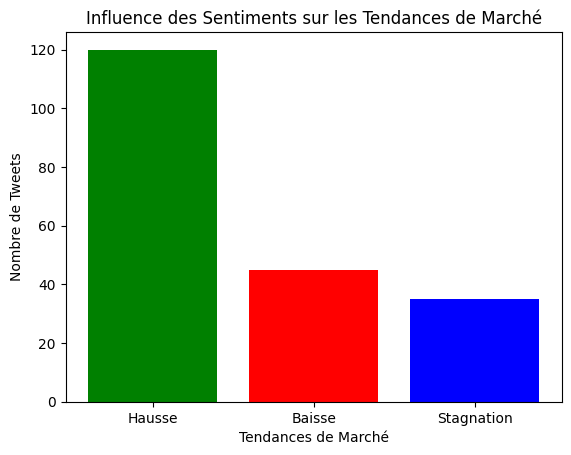

In [ ]:
import matplotlib.pyplot as plt

# Données d'exemple (à remplacer par les résultats de vos requêtes SPARQL)
tendances = ["Hausse", "Baisse", "Stagnation"]
nombre_tweets = [120, 45, 35]  # Nombre de tweets associés à chaque tendance

# Créer un graphique à barres
plt.bar(tendances, nombre_tweets, color=["green", "red", "blue"])
plt.xlabel("Tendances de Marché")
plt.ylabel("Nombre de Tweets")
plt.title("Influence des Sentiments sur les Tendances de Marché")
plt.show()

In [ ]:
from rdflib import Graph

# Charger l'ontologie unifiée
g = Graph()
g.parse("unified_ontology.ttl", format="turtle")

# Définir le namespace
ns = {"ns": "http://example.org/unified-ontology#"}

# Fonction pour exécuter une requête SPARQL
def executer_requete_sparql(query):
    results = g.query(query, initNs=ns)
    if len(results) > 0:
        for row in results:
            print(row)
    else:
        print("Aucun résultat trouvé.")

# Exemple 1 : Trouver tous les produits
query_produits = """
PREFIX ns: <http://example.org/unified-ontology#>
SELECT ?produit
WHERE {
  ?produit a ns:Produit .
}
"""
print("Tous les produits :")
executer_requete_sparql(query_produits)

# Exemple 2 : Trouver les produits avec des avis positifs
query_avis_positifs = """
PREFIX ns: <http://example.org/unified-ontology#>
SELECT ?produit ?avis
WHERE {
  ?produit ns:aPourAvis ?avis .
  ?avis ns:influenceTendance ns:tendance_hausse .
}
"""
print("\nProduits avec des avis positifs :")
executer_requete_sparql(query_avis_positifs)

# Exemple 3 : Trouver les tendances influencées par un sentiment positif
query_tendances_positives = """
PREFIX ns: <http://example.org/unified-ontology#>
SELECT ?tendance
WHERE {
  ns:sentiment_positif ns:influenceTendance ?tendance .
}
"""
print("\nTendances influencées par un sentiment positif :")
executer_requete_sparql(query_tendances_positives)

# Exemple 4 : Trouver les tweets associés à une tendance à la baisse
query_tweets_tendance_baisse = """
PREFIX ns: <http://example.org/unified-ontology#>
SELECT ?tweet ?texte
WHERE {
  ?tweet ns:aPourSentiment ns:sentiment_negatif .
  ?tweet ns:aPourTexte ?texte .
  ?tweet ns:aPourProduit ?produit .
  ?produit ns:aPourAvis ?avis .
  ?avis ns:influenceTendance ns:tendance_baisse .
}
"""
print("\nTweets associés à une tendance à la baisse :")
executer_requete_sparql(query_tweets_tendance_baisse)

Tous les produits :
Aucun résultat trouvé.

Produits avec des avis positifs :
Aucun résultat trouvé.

Tendances influencées par un sentiment positif :
Aucun résultat trouvé.

Tweets associés à une tendance à la baisse :
Aucun résultat trouvé.


In [ ]:
from rdflib import Graph

# Charger l'ontologie
g = Graph()
g.parse("unified_ontology.ttl", format="turtle")

# Requête SPARQL pour afficher 10 triplets
query = """
SELECT ?s ?p ?o
WHERE {
  ?s ?p ?o .
}
LIMIT 10
"""

# Exécuter la requête
results = g.query(query)

# Afficher les résultats
for row in results:
    print(f"Sujet : {row.s}, Prédicat : {row.p}, Objet : {row.o}")

Sujet : http://example.org/tweet/faae6e2fa3, Prédicat : http://example.org/sentiment-analysis#aPourTexte, Objet : Man, looking through and packing up my books is looking at my past lives. Feeling kind of sentimental
Sujet : http://example.org/tweet/64c7ef8355, Prédicat : http://example.org/sentiment-analysis#aPourTexte, Objet :  Hi!! How are you? You`re an amazning actress  Greets from Slovenia
Sujet : http://example.org/tweet/13d1cd323a, Prédicat : http://www.w3.org/1999/02/22-rdf-syntax-ns#type, Objet : http://example.org/sentiment-analysis#Tweet
Sujet : http://example.org/tweet/4e4dd166c0, Prédicat : http://example.org/sentiment-analysis#aPourTemps, Objet : noon
Sujet : http://example.org/tweet/33596d8109, Prédicat : http://www.w3.org/1999/02/22-rdf-syntax-ns#type, Objet : http://example.org/sentiment-analysis#Tweet
Sujet : http://example.org/utilisateur/cc26205f91, Prédicat : http://www.w3.org/1999/02/22-rdf-syntax-ns#type, Objet : http://example.org/sentiment-analysis#Utilisateur
